In [2]:
# import packages and libraries
import pandas as pd
import lightgbm
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
import uuid
import os
init_notebook_mode(connected=True)
from sklearn.neighbors import KNeighborsRegressor
from modAL.models import ActiveLearner
import random
import sys
from random import randint
import pickle
from datetime import datetime
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
import matplotlib.pyplot as plt

from modAL.models import ActiveLearner
from modAL.models import CommitteeRegressor
from modAL.disagreement import max_std_sampling
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

In [3]:
def rmse(true_values, predicted_values):
    n = len(true_values)
    residuals = 0
    for i in range(n):
        residuals += (true_values[i] - predicted_values[i]) ** 2.
    return np.sqrt(residuals / n)

In [4]:
#ensure repetabillity
seed = random.randrange(sys.maxsize)
random.seed(123456)
seed_list = []
for i in range(35):
    seed_list.append(randint(0, 4292967297))
#seed_list

In [5]:
input_file = 'ElctrMotorTemp_ML.txt'
file_object = open(input_file, 'rb')
str_mdl = file_object.read()
model = pickle.loads(str_mdl)

[23:56:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [6]:
# validate on the random predictions from this range
actual_lows = {'ambient': -8.5, 'coolant': -1.4, 'u_d': -1.65, 'u_q': -1.8, 'motor_speed': -1.37,
              'torque': -3.3, 'i_d': -3.2, 'i_q': -3.3}  #, 'pm':[-2.6]}
actual_highs = {'ambient': 2.9, 'coolant': 2.6, 'u_d': 2.27, 'u_q': 1.79, 'motor_speed': 2.02,
              'torque': 3, 'i_d': 1.06, 'i_q': 2.9 }  #, 'pm':[2.9]}
variables_ = ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q', 'pm']
samples_ = 10000

def random_generator(samples_, actual_lows, actual_highs, variables_, model):
    df_doe = pd.DataFrame(columns=variables_[:-1])
    for var in variables_[:-1]:
        df_doe[var] = np.random.uniform(actual_lows[var], actual_highs[var],
                                        samples_).round(3)
    try:
        df_doe[variables_[-1]] = model.predict(np.array(df_doe)).round(3)
    except:
        df_doe[variables_[-1]] = model.predict(df_doe).round(3)
    return df_doe

def latin_hypercube_generator(samples_, actual_lows, actual_highs, variables, model):
    # actual_lows = {'AT': [2], 'V': [30], 'AP': [993], 'RH': [30]}  # , 'PE':[425]}
    # actual_highs = {'AT': [35], 'V': [80], 'AP': [1033], 'RH': [100]}  # , 'PE':[495]}
    # variables = ['AT', 'V', 'AP', 'RH', 'PE']
    # samples_ = 100000
    # np.random.seed(5234)
    df_doe = pd.DataFrame(lhs(len(variables) - 1, samples=samples_, criterion='maximin'))
    df_doe.columns = variables[:-1]
    for col in df_doe.columns:
        df_doe[col] = [actual_lows[col]] * df_doe.shape[0] + df_doe[col] * (actual_highs[col] - actual_lows[col])
        df_doe[col] = df_doe[col].apply(lambda x: round(x, 3))
    # df_doe = df_doe.reset_index()
    df_doe.columns = variables[:-1]
    try:
        df_doe[variables_[-1]] = model.predict(np.array(df_doe)).round(3)
    except:
        df_doe[variables_[-1]] = model.predict(df_doe).round(3)
    return df_doe

def normalize(input_array):
    mean = np.mean(input_array, axis=0)
    std = np.std(input_array, axis=0)

    # scikit-learn measure to handle zeros in scale: def _handle_zeros_in_scale(scale, copy=True)
    # https://github.com/scikit-learn/scikit-learn/blob/7389dbac82d362f296dc2746f10e43ffa1615660/sklearn/preprocessing/data.py#L70
    # if np.isscalar(std):
    #     if std == .0:
    #         std = 1.
    # elif isinstance(std, np.ndarray):
    #     std = std.copy()
    #     std[std == 0.0] = 1.0
    min = np.min(input_array, axis=0)
    max = np.max(input_array, axis=0)
    data_norm = (max - input_array) / (max - min)
    #data_norm = (input_array - mean) / std
    return min, max, data_norm


df = random_generator(samples_, actual_lows, actual_highs, variables_, model)
print(df['pm'].min(), df['pm'].max())

-0.831 2.012


Validate

In [7]:
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import lightgbm
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from pyDOE import lhs


cv_folds = 30
seedSize = 50
batchSize_mcs = 5
batchSize_lhc = 5
batchSize_qbc = 5
batchSize_gpr_al = 1
size_train_set = 400

committee_predictor = False

trainingSetSizes_mcs = np.arange(seedSize, size_train_set+1, batchSize_mcs)
trainingSetSizes_lhc = np.arange(seedSize, size_train_set+1, batchSize_lhc)
# trainingSetSizes_qbc = np.arange(seedSize, size_train_set+1, batchSize_qbc)
# trainingSetSizes_gpr_al = np.arange(seedSize, size_train_set+1, batchSize_gpr_al)
pth = str(Path().cwd().parents[1] / Path('01_Data') / Path('lhc_designs')) + str(Path("/"))

In [8]:
#validation set
size_test_set = 1000
reference_regr = model
np.random.seed(83746293)
test_data = latin_hypercube_generator(size_test_set, actual_lows, actual_highs, variables_, reference_regr)
test_data = np.array(test_data)
# test_data = np.load(pth + 'lhc_test_pumadyn-32_sz_2000_randseed_83746293.npy')
# size_test_set = test_data.shape[0]

# mcs_extension

In [9]:
#count_mcs = 0

In [10]:
#count_mcs = 1
results_random = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('val {}'.format(cv))
    # for trainSize in trainingSetSizes_mcs:
    #for trainSize in range(seedSize, size_train_set+1):
    np.random.seed(seed_list[cv])
    train_data = np.array(random_generator(seedSize-batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
    for trainSize in trainingSetSizes_mcs:

        lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]

        train_data_add = np.array(random_generator(batchSize_mcs, actual_lows, actual_highs, variables_, reference_regr))
        train_data = np.concatenate((train_data, train_data_add), axis=0)
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_test = test_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_test = test_data[:, -1].reshape((-1, 1))

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0]:, -1].reshape((-1, 1))


        if committee_predictor:
            learner_list = []
            for i in range(numCommitteeMembers):
                learner_list.append(ActiveLearner(estimator=predictor,
                                                  X_training=X_train_norm,
                                                  y_training=y_train_norm.ravel(),
                                                  #bootstrap_init=True
                                                 ))
            committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            mcs_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #mcs_y = mcs_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        mcs_y = max_data[-1].reshape((-1, 1)) - mcs_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        preds_mcs = np.ravel(mcs_y)
        targets_mcs = np.ravel(y_test)
        r2_val = r2_score(targets_mcs, preds_mcs)
        rmse_val = rmse(targets_mcs, preds_mcs)

        #print('train size mcs {}'.format(trainSize))
        #print(r2_score(targets_mcs, preds_mcs))
        
        results_random.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_random = pd.DataFrame(results_random)

val 0
Total time fold 0 trainSize 400: 0:00:00.233490 
val 1
Total time fold 1 trainSize 400: 0:00:00.213485 
val 2
Total time fold 2 trainSize 400: 0:00:00.208150 
val 3
Total time fold 3 trainSize 400: 0:00:00.214411 
val 4
Total time fold 4 trainSize 400: 0:00:00.200395 
val 5
Total time fold 5 trainSize 400: 0:00:00.193077 
val 6
Total time fold 6 trainSize 400: 0:00:00.181585 
val 7
Total time fold 7 trainSize 400: 0:00:00.176976 
val 8
Total time fold 8 trainSize 400: 0:00:00.183896 
val 9
Total time fold 9 trainSize 400: 0:00:00.189340 
val 10
Total time fold 10 trainSize 400: 0:00:00.188910 
val 11
Total time fold 11 trainSize 400: 0:00:00.173660 
val 12
Total time fold 12 trainSize 400: 0:00:00.178213 
val 13
Total time fold 13 trainSize 400: 0:00:00.182801 
val 14
Total time fold 14 trainSize 400: 0:00:00.184786 
val 15
Total time fold 15 trainSize 400: 0:00:00.187967 
val 16
Total time fold 16 trainSize 400: 0:00:00.171590 
val 17
Total time fold 17 trainSize 400: 0:00:00.17

In [25]:
res_df_random[res_df_random.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.486785,0.125969
71,LGBMRegressor,1,50,0.504421,0.061489
142,LGBMRegressor,2,50,0.481271,0.145659
213,LGBMRegressor,3,50,0.518552,0.008171
284,LGBMRegressor,4,50,0.449227,0.255639
355,LGBMRegressor,5,50,0.513017,0.029231
426,LGBMRegressor,6,50,0.483935,0.136174
497,LGBMRegressor,7,50,0.464203,0.205182
568,LGBMRegressor,8,50,0.459157,0.222368
639,LGBMRegressor,9,50,0.489972,0.114488


In [12]:
res_df_random[res_df_random.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.147535,0.919714
141,LGBMRegressor,1,400,0.138786,0.928954
212,LGBMRegressor,2,400,0.161277,0.904061
283,LGBMRegressor,3,400,0.148105,0.919092
354,LGBMRegressor,4,400,0.131002,0.936699
425,LGBMRegressor,5,400,0.147202,0.920075
496,LGBMRegressor,6,400,0.143684,0.923850
567,LGBMRegressor,7,400,0.115300,0.950964
638,LGBMRegressor,8,400,0.129287,0.938346
709,LGBMRegressor,9,400,0.140736,0.926943


# lhc

In [13]:
#count_lhc = 0

In [14]:
numCommitteeMembers = 3

results_lhc = []
for cv in range(cv_folds):
    startTime = datetime.now()
    print('seed {}'.format(cv))
    for trainSize in trainingSetSizes_lhc:
        np.random.seed(seed_list[cv])
#         try:
#             fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#             fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
#             train_data =  np.load(pth + fname_t)
#             pool_data = np.load(pth + fname_p)
#         except:
#             # print('lhc file not found')
        train_data = np.array(
            latin_hypercube_generator(trainSize, actual_lows, actual_highs, variables_, reference_regr))
        #print(train_data[0])
        pool_data = np.array(latin_hypercube_generator(size_train_set, actual_lows, actual_highs, variables_,
                                  reference_regr))
#             fname_t = 'lhc_train_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
#             fname_p = 'lhc_pool_pumadyn-32_sz_' + str(trainSize) + '_randseed_' + str(seed_list[cv])
#             np.save(pth + fname_t, train_data)
#             np.save(pth + fname_p, pool_data)
        
        lgbmParams = {  # 'learning_rate': 0.1,
            'n_estimators': 100,
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': seed_list[cv]
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
        pred_str = str(predictor)
        pred_key = pred_str[:pred_str.find('(')]
        
        # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
        min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))

        X_train = train_data[:, :-1]
        X_pool = pool_data[:, :-1]
        y_train = train_data[:, -1].reshape((-1, 1))
        y_pool = pool_data[:, -1].reshape((-1, 1))
        X_test = test_data[:, :-1]
        y_test = test_data[:, -1]

        # NORMALIZED DATA
        X_train_norm = data_all_norm[:train_data.shape[0], :-1]
        y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
        X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
        y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
        X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
        y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

        #print(X_train_norm[0])
        # rr_params_v1 = {
        #     'alpha': 5, 'max_iter': 4, 'normalize': False, 'solver': 'lsqr', 'tol': 0.003}
        # predictor = Ridge(**rr_params_v1)

        learner_list=[]
        for i in range(numCommitteeMembers):
            learner_list.append(ActiveLearner(estimator=predictor,
                                              # estimator=sklearn.base.clone(predictor),
                                              X_training=X_train_norm,
                                              y_training=y_train_norm.ravel(),
                                              bootstrap_init=True
                                             ))
        committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)


        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        #qbc_y = qbc_y_norm * std_data[-1].reshape((-1, 1)) + mean_data[-1].reshape((-1, 1))
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
                    max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))


        # -------->  SAVING THE PREDICTED AND TARGET VALUES  <------------------
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)

        #print(r2_score(targets_qbc, preds_qbc))
        r2_val = r2_score(targets_qbc, preds_qbc)
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_lhc.append({'Model': pred_key, 'CV': cv, 'Training_Size': trainSize,
                       'RMSE': rmse_val, 'r2_val': r2_val})
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, trainSize, (endTime - startTime) / 60))
        
res_df_lhc = pd.DataFrame(results_lhc)

    # count_lhc+=1

seed 0
Total time fold 0 trainSize 400: 0:00:08.925382 
seed 1
Total time fold 1 trainSize 400: 0:00:09.006337 
seed 2
Total time fold 2 trainSize 400: 0:00:09.327266 
seed 3
Total time fold 3 trainSize 400: 0:00:07.900530 
seed 4
Total time fold 4 trainSize 400: 0:00:07.796744 
seed 5
Total time fold 5 trainSize 400: 0:00:07.786909 
seed 6
Total time fold 6 trainSize 400: 0:00:07.789995 
seed 7
Total time fold 7 trainSize 400: 0:00:03.757578 
seed 8
Total time fold 8 trainSize 400: 0:00:03.152103 
seed 9
Total time fold 9 trainSize 400: 0:00:03.146486 
seed 10
Total time fold 10 trainSize 400: 0:00:03.153126 
seed 11
Total time fold 11 trainSize 400: 0:00:03.143354 
seed 12
Total time fold 12 trainSize 400: 0:00:03.137453 
seed 13
Total time fold 13 trainSize 400: 0:00:03.144488 
seed 14
Total time fold 14 trainSize 400: 0:00:03.136759 
seed 15
Total time fold 15 trainSize 400: 0:00:03.140858 
seed 16
Total time fold 16 trainSize 400: 0:00:03.145598 
seed 17
Total time fold 17 trainSi

In [15]:
res_df_lhc[res_df_lhc.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.517846,0.010871
71,LGBMRegressor,1,50,0.512956,0.029461
142,LGBMRegressor,2,50,0.484898,0.132732
213,LGBMRegressor,3,50,0.494580,0.097753
284,LGBMRegressor,4,50,0.462583,0.210720
355,LGBMRegressor,5,50,0.449861,0.253535
426,LGBMRegressor,6,50,0.495576,0.094114
497,LGBMRegressor,7,50,0.484146,0.135419
568,LGBMRegressor,8,50,0.502302,0.069359
639,LGBMRegressor,9,50,0.470587,0.183168


In [16]:
res_df_lhc[res_df_lhc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.130666,0.937024
141,LGBMRegressor,1,400,0.135361,0.932417
212,LGBMRegressor,2,400,0.129262,0.938370
283,LGBMRegressor,3,400,0.130053,0.937613
354,LGBMRegressor,4,400,0.147825,0.919397
425,LGBMRegressor,5,400,0.125995,0.941446
496,LGBMRegressor,6,400,0.131682,0.936041
567,LGBMRegressor,7,400,0.129917,0.937744
638,LGBMRegressor,8,400,0.135800,0.931977
709,LGBMRegressor,9,400,0.128251,0.939330


# AL with qbc

In [17]:
#count_qbc = 0

In [18]:
# cv_folds = 10

In [19]:
count_qbc= 0
PoolSetSize = 360 #260#260 #400
batchSize = 5
seedSize = 50
n_queries = 70

numCommitteeMembers = 3

results_qbc_t = []
for cv in range(cv_folds):
    learner_list = []
    startTime = datetime.now()
    
     # --------> Data Generation (subtraction of the mean, division by standard deviation) <------------------
    print('lhc file not found')
    np.random.seed(seed_list[cv]) 
    #print('seed {}'.format(cv))
    pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
    
      # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
    min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
    X_train = train_data[:, :-1]
    X_pool = pool_data[:, :-1]
    y_train = train_data[:, -1].reshape((-1, 1))
    y_pool = pool_data[:, -1].reshape((-1, 1))
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]

    # NORMALIZED DATA
    X_train_norm = data_all_norm[:train_data.shape[0], :-1]
    y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
    X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
    y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
    X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
    y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
     # --------> Create commitee <------------------
    # est = [100, 120, 140]
    # num_leaves = [6,11,16]
    # num_leaves = [8,11,14]
    X_train_norm_init = X_train_norm.copy()
    y_train_norm_init = y_train_norm.copy()
    for i in range(numCommitteeMembers):
        #print(X_train_norm_init.shape)
        train_idx = np.random.choice(range(X_train_norm_init.shape[0]), 
                                     size=int(0.7*X_train.shape[0]),
                                     #size=int(X_train.shape[0]/numCommitteeMembers), 
                                     replace=False)
        lgbmParams = {  # 'learning_rate': 0.1,
            # 'n_estimators': est[i],
            # 'num_leaves': num_leaves[i],
            'objective': 'regression',
            'n_jobs': 7,
            'random_state': i*100
            }
        predictor = lightgbm.LGBMRegressor(**lgbmParams)
#         predictor = RandomForestRegressor(max_depth=num_leaves[i], 
#                                   random_state=i*100, 
#                                   #n_estimators=100, 
#                                   n_jobs=7)
        #print(train_idx)
        learner_list.append(ActiveLearner(estimator=predictor,
                                          # estimator=sklearn.base.clone(predictor),
                                          X_training=X_train_norm_init[train_idx],
                                          y_training=y_train_norm_init[train_idx].ravel(),
                                          bootstrap_init=True
                                         ))
        
#         X_train_norm_init = np.delete(X_train_norm_init, train_idx, axis=0)
#         y_train_norm_init = np.delete(y_train_norm_init, train_idx)
        
    # assembling the committee    
    committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    #committee.rebag()

    committee.fit(X_train_norm, y_train_norm.ravel())
     #  -------->  Initial Evaluation  <------------------
    if committee_predictor:
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)

    
    for itter in range(n_queries+1):
        #print(itter)
        if committee_predictor:
            #  -------->  MODEL FITTING  <------------------
            committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = committee.predict(X_test_norm)
        else:
            #committee.teach(X_train_norm, y_train_norm.ravel())
            #  -------->  MODEL FITTING  <------------------
            predictor.fit(X_train_norm, y_train_norm.ravel())
            #  -------->  PREDICTION  <------------------
            qbc_y_norm = predictor.predict(X_test_norm)

        # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
        qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
        preds_qbc = np.ravel(qbc_y)
        targets_qbc = np.ravel(y_test)
        #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

        r2_val = r2_score(targets_qbc, preds_qbc)
        #print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
        rmse_val = rmse(targets_qbc, preds_qbc)

        results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                       'RMSE': rmse_val, 'r2_val': r2_val})

        # -------->  Pick new point  <------------------
        query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize, random_tie_break=True)
        X_train = np.append(X_train, X_pool[query_idx], axis=0)
        y_train = np.append(y_train, y_pool[query_idx], axis=0)
        X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
        y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
        committee.teach(X_pool_norm[query_idx],
                        y_pool_norm.ravel()[query_idx])  # train committee on newly added data
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
        y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
        # print(X_pool_norm.shape)
    endTime = datetime.now()
    print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

lhc file not found
Total time fold 0 trainSize 405: 0:00:00.125816 
lhc file not found
Total time fold 1 trainSize 405: 0:00:00.128958 
lhc file not found
Total time fold 2 trainSize 405: 0:00:00.129458 
lhc file not found
Total time fold 3 trainSize 405: 0:00:00.130056 
lhc file not found
Total time fold 4 trainSize 405: 0:00:00.132418 
lhc file not found
Total time fold 5 trainSize 405: 0:00:00.130399 
lhc file not found
Total time fold 6 trainSize 405: 0:00:00.132328 
lhc file not found
Total time fold 7 trainSize 405: 0:00:00.131447 
lhc file not found
Total time fold 8 trainSize 405: 0:00:00.134412 
lhc file not found
Total time fold 9 trainSize 405: 0:00:00.131702 
lhc file not found
Total time fold 10 trainSize 405: 0:00:00.131009 
lhc file not found
Total time fold 11 trainSize 405: 0:00:00.133642 
lhc file not found
Total time fold 12 trainSize 405: 0:00:00.134094 
lhc file not found
Total time fold 13 trainSize 405: 0:00:00.134761 
lhc file not found
Total time fold 14 trainS

In [20]:
res_df_qbc[res_df_qbc.Training_Size==50]

,Model,CV,Training_Size,RMSE,r2_val
0,LGBMRegressor,0,50,0.501249,0.073257
71,LGBMRegressor,1,50,0.479218,0.152932
142,LGBMRegressor,2,50,0.496132,0.092083
213,LGBMRegressor,3,50,0.520290,0.001510
284,LGBMRegressor,4,50,0.473277,0.173804
355,LGBMRegressor,5,50,0.499693,0.079004
426,LGBMRegressor,6,50,0.483336,0.138312
497,LGBMRegressor,7,50,0.488888,0.118400
568,LGBMRegressor,8,50,0.457873,0.226709
639,LGBMRegressor,9,50,0.505135,0.058833


In [21]:
res_df_qbc[res_df_qbc.Training_Size==400]

,Model,CV,Training_Size,RMSE,r2_val
70,LGBMRegressor,0,400,0.133156,0.934600
141,LGBMRegressor,1,400,0.141033,0.926634
212,LGBMRegressor,2,400,0.130465,0.937217
283,LGBMRegressor,3,400,0.130640,0.937049
354,LGBMRegressor,4,400,0.126794,0.940701
425,LGBMRegressor,5,400,0.126753,0.940739
496,LGBMRegressor,6,400,0.129754,0.937899
567,LGBMRegressor,7,400,0.134674,0.933101
638,LGBMRegressor,8,400,0.123527,0.943717
709,LGBMRegressor,9,400,0.130355,0.937323


# AL with Gaussian Process Regressor

In [22]:
# count_gpr = 0

In [23]:
# import warnings
# warnings.filterwarnings("ignore")

# def GP_regression_std(regressor, X):
#     _, std = regressor.predict(X, return_std=True)
#     query_idx = np.argmax(std)
#     return query_idx, X[query_idx]

# numCommitteeMembers = 3
# PoolSetSize = 601
# seedSize = 50

# results_al_gpr = []
# for cv in range(cv_folds):
#     startTime = datetime.now()
#     print('seed {}'.format(cv))
#     for i in range(numCommitteeMembers):
#         lgbmParams = {  # 'learning_rate': 0.1,
#             'n_estimators': 100,
#             'objective': 'regression',
#             'n_jobs': 7,
#             'random_state': i
#             }
#         predictor = lightgbm.LGBMRegressor(**lgbmParams)
# #         learner_list.append(ActiveLearner(estimator=predictor,
# #                                           # estimator=sklearn.base.clone(predictor),
# #                                           X_training=X_train_norm,
# #                                           y_training=y_train_norm.ravel(),
# #                                           bootstrap_init=True))
# #     committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
    
#     np.random.seed(seed_list[cv])
    
# #     try:
# #         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
# #         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv]) + '.npy'
# #         train_data =  np.load(pth + fname_t)
# #         pool_data = np.load(pth + fname_p)
# #     except:
# #         print('lhc file not found')
# #         np.random.seed(seed_list[cv])
#     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_,
#                               reference_regr))
# #         fname_t = 'lhc_train_pumadyn-32_sz_' + str(seedSize) + '_randseed_' + str(seed_list[cv])
# #         fname_p = 'lhc_pool_pumadyn-32_sz_' + str(PoolSetSize) + '_randseed_' + str(seed_list[cv])
# #         np.save(pth + fname_t, train_data)
# #         np.save(pth + fname_p, pool_data)
    
# #     train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
# #     pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
    
#     # --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
#     min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
#     X_train = train_data[:, :-1]
#     X_pool = pool_data[:, :-1]
#     y_train = train_data[:, -1].reshape((-1, 1))
#     y_pool = pool_data[:, -1].reshape((-1, 1))
#     X_test = test_data[:, :-1]
#     y_test = test_data[:, -1]

#     # NORMALIZED DATA
#     X_train_norm = data_all_norm[:train_data.shape[0], :-1]
#     y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
#     X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
#     y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
#     X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
#     y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
    
#     # Create GPR as an active learner
#     kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
#          + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
#     committee = ActiveLearner(
#         estimator=GaussianProcessRegressor(kernel=kernel),
#         query_strategy=GP_regression_std,
#         X_training=X_train_norm, y_training=y_train_norm.ravel()
#         )
    
#     committee.fit(X_train_norm, y_train_norm.ravel())
#     for itter in range(size_train_set-seedSize+1):
#         if committee_predictor:
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = committee.predict(X_test_norm)
#         else:
#             #  -------->  MODEL FITTING  <------------------
#             predictor.fit(X_train_norm, y_train_norm.ravel())
#             #  -------->  PREDICTION  <------------------
#             al_gpr_y_norm = predictor.predict(X_test_norm)

#         # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
#         al_gpr_y = max_data[-1].reshape((-1, 1)) - al_gpr_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
#         preds_al_gpr = np.ravel(al_gpr_y)
#         targets_al_gpr = np.ravel(y_test)
        
#         r2_val = r2_score(targets_al_gpr, preds_al_gpr)
#         rmse_val = rmse(targets_al_gpr, preds_al_gpr)

#         results_al_gpr.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
#                        'RMSE': rmse_val, 'r2_val': r2_val})

#         # -------->  Pick new point  <------------------
#         query_idx, query_instance = committee.query(X=X_pool_norm)
#         X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
#         y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
#         committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())  # train committee on newly added data
#         X_pool = np.delete(X_pool, query_idx, axis=0)
#         y_pool = np.delete(y_pool, query_idx, axis=0)
#         X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
#         y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)

#     endTime = datetime.now()
#     print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
        
# res_df_al_gpr = pd.DataFrame(results_al_gpr)

In [24]:
res_df_al_gpr[res_df_al_gpr.Training_Size==50]

NameError: name 'res_df_al_gpr' is not defined

In [ ]:
res_df_al_gpr[res_df_al_gpr.Training_Size==400]

# Visualize

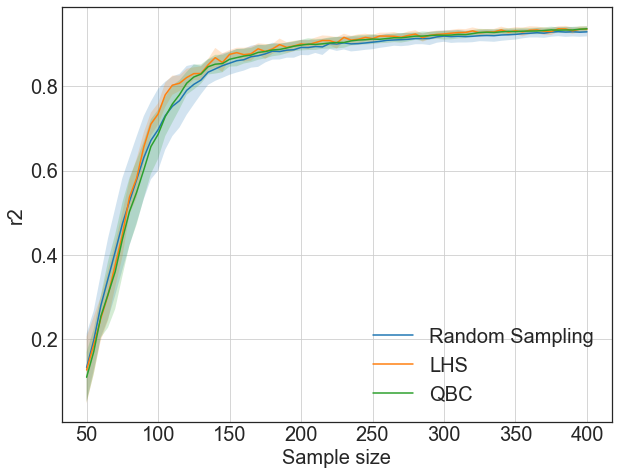

In [30]:
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}

plt.rc('font', **font)


def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    #plt.title(title)
    plt.grid()
    #plt.figure(figsize=(6,6))
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'Random Sampling', metadata)
        plot_learning_curve_r2(res_df_lhc, 'LHS', metadata)
        plot_learning_curve_r2(res_df_qbc, 'QBC', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        plt.legend(loc='lower right')
        plt.tight_layout()
        fig.savefig('EMT_al_lhc_mcs_results_' + mdl + '.png', dpi=300)
        plt.show()

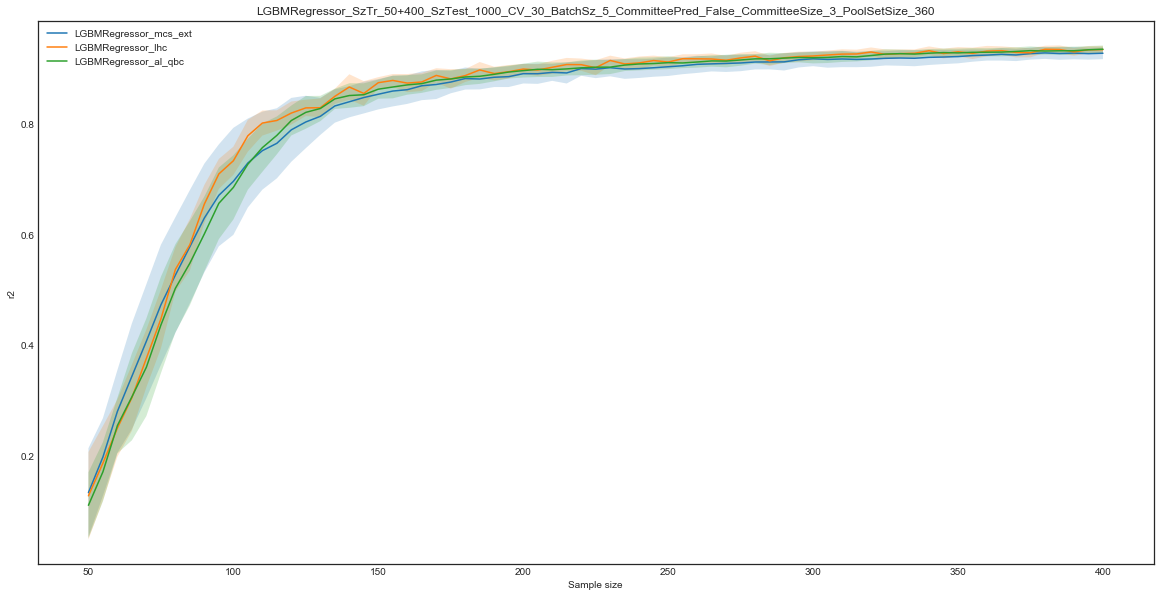

In [26]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers) + '_PoolSetSize_' + str(PoolSetSize)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

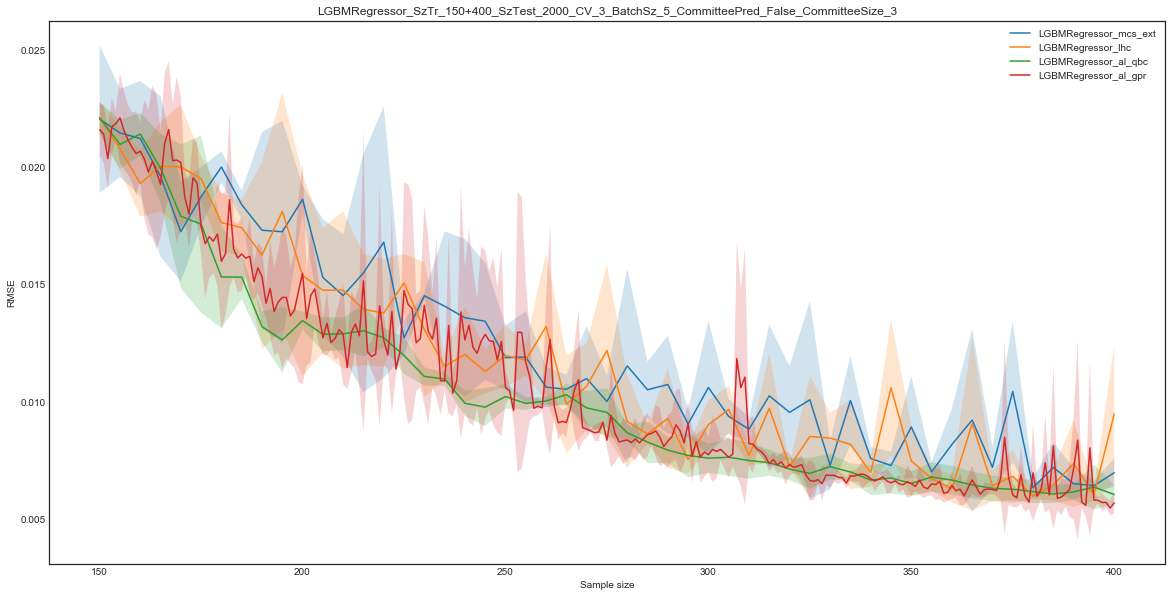

In [146]:
def plot_learning_curve_rmse(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).RMSE.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.RMSE, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.RMSE - df_target_std.RMSE,
                     df_target_mean.RMSE + df_target_std.RMSE, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('RMSE')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_rmse(res_df_random, 'mcs_ext', metadata)
        plot_learning_curve_rmse(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_rmse(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_rmse(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

# Old GPR

In [69]:
count_gpr = 0

In [70]:
PoolSetSize = 251
seedSize = 150
n_queries = 250

lgbmParams = {  # 'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'regression',
    'n_jobs': 1,
    'random_state': seed_list[count_gpr]
    }

predictor = lightgbm.LGBMRegressor(**lgbmParams)
print('seed {}'.format(count_gpr))
#print('seed {}'.format(count_gpr))
np.random.seed(seed_list[count_gpr])
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]

from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

#n_initial = 50
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

committee = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_train_norm, y_training=y_train_norm.ravel()
)
#committee.fit(X_train_norm, y_train_norm.ravel())
qbc_y_norm = committee.predict(X_test_norm)
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))

preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
r2_score(targets_qbc, preds_qbc)



import warnings
warnings.filterwarnings("ignore")

#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR before, train size {}'.format(X_train_norm.shape[0]))
#print(X_train_norm[0])
print(r2_score(targets_qbc, preds_qbc))
      
#np.random.seed(12345)
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool_norm)
    #print(X_pool_norm[0])
#     print(query_idx)
#     print(query_instance)
    
    #X_train = np.append(X_train, X_pool[query_idx].reshape(1,-1), axis=0)
    #y_train = np.append(y_train, y_pool[query_idx].reshape(1,-1), axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx].reshape(1,-1), axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx].reshape(1,-1), axis=0)
    
    committee.teach(X_pool_norm[[query_idx]], y_pool_norm[[query_idx]].ravel())
    
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    
#  -------->  MODEL FITTING  <------------------
predictor.fit(X_train_norm, y_train_norm.ravel())
#  -------->  PREDICTION  <------------------
qbc_y_norm = predictor.predict(X_test_norm)
# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (
            max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
# -------->  Evaluation  <------------------
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
print('AL GPR after, train size {}'.format(X_train_norm.shape[0]))
print(r2_score(targets_qbc, preds_qbc))
count_gpr += 1

seed 1
AL GPR before, train size 150
0.2847234742263258
AL GPR after, train size 400
0.9459554964591618


# Tune QBC

In [32]:
count_qbc= 0

In [23]:
count_qbc= 2
PoolSetSize = 260 #400
batchSize = 5
seedSize = 150
n_queries = 50

numCommitteeMembers = 3

results_qbc_t = []
learner_list = []
results_qbc_t = []

startTime = datetime.now()
for i in range(numCommitteeMembers):
    lgbmParams = {  # 'learning_rate': 0.1,
        'n_estimators': 100,
        'objective': 'regression',
        'n_jobs': 7,
        'random_state': i*100
        }
    predictor = lightgbm.LGBMRegressor(**lgbmParams)
    learner_list.append(ActiveLearner(estimator=predictor,
                                      # estimator=sklearn.base.clone(predictor),
                                      X_training=X_train_norm,
                                      y_training=y_train_norm.ravel(),
                                      #bootstrap_init=True
                                     ))
committee = CommitteeRegressor(learner_list=learner_list, query_strategy=max_std_sampling)
np.random.seed(seed_list[count_qbc])
print('seed {}'.format(count_qbc))
train_data = np.array(latin_hypercube_generator(seedSize, actual_lows, actual_highs, variables_, reference_regr))
#print(train_data[0])
#np.random.seed(seed_list[cv])
pool_data = np.array(latin_hypercube_generator(PoolSetSize, actual_lows, actual_highs, variables_, reference_regr))
#print(pool_data[0])
print('1')
# --------> STANDARDIZATION OF DATA SETS (subtraction of the mean, division by standard deviation) <------------------
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))
print('1')


committee.fit(X_train_norm, y_train_norm.ravel())
 #  -------->  Initial Evaluation  <------------------
if committee_predictor:
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = committee.predict(X_test_norm)
else:
    #  -------->  MODEL FITTING  <------------------
    predictor.fit(X_train_norm, y_train_norm.ravel())
    #  -------->  PREDICTION  <------------------
    qbc_y_norm = predictor.predict(X_test_norm)
print('1')
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)

#print('QBC before, train size {}'.format(X_train_norm.shape[0]))
#print(r2_score(targets_qbc, preds_qbc))



for itter in range(n_queries+1):
    #print(itter)
    if committee_predictor:
        #  -------->  MODEL FITTING  <------------------
        committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = committee.predict(X_test_norm)
    else:
        #committee.teach(X_train_norm, y_train_norm.ravel())
        #  -------->  MODEL FITTING  <------------------
        predictor.fit(X_train_norm, y_train_norm.ravel())
        #  -------->  PREDICTION  <------------------
        qbc_y_norm = predictor.predict(X_test_norm)

    # -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
    qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
    preds_qbc = np.ravel(qbc_y)
    targets_qbc = np.ravel(y_test)
    #print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))

    r2_val = r2_score(targets_qbc, preds_qbc)
    print('size {}, r2 {}'.format(X_train_norm.shape[0], r2_val))
    rmse_val = rmse(targets_qbc, preds_qbc)

    results_qbc_t.append({'Model': pred_key, 'CV': cv, 'Training_Size': X_train_norm.shape[0],
                   'RMSE': rmse_val, 'r2_val': r2_val})

    # -------->  Pick new point  <------------------
    query_idx, query_instance = committee.query(X=X_pool_norm, n_instances=batchSize)
    X_train = np.append(X_train, X_pool[query_idx], axis=0)
    y_train = np.append(y_train, y_pool[query_idx], axis=0)
    X_train_norm = np.append(X_train_norm, X_pool_norm[query_idx], axis=0)
    y_train_norm = np.append(y_train_norm, y_pool_norm[query_idx], axis=0)
    committee.teach(X_pool_norm[query_idx],
                    y_pool_norm.ravel()[query_idx])  # train committee on newly added data
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    X_pool_norm = np.delete(X_pool_norm, query_idx, axis=0)
    y_pool_norm = np.delete(y_pool_norm, query_idx, axis=0)
    # print(X_pool_norm.shape)

endTime = datetime.now()
print('Total time fold {} trainSize {}: {} '.format(cv, X_train_norm.shape[0], (endTime - startTime) / 60))
res_df_qbc = pd.DataFrame(results_qbc_t)
count_qbc+=1

seed 2
1
1
1
size 150, r2 0.35445386655170497
size 155, r2 0.340873770610048
size 160, r2 0.38841403268328645
size 165, r2 0.3864077306869165
size 170, r2 0.4390538958775101
size 175, r2 0.5588433343854644
size 180, r2 0.5095936092298412
size 185, r2 0.6942965612891441
size 190, r2 0.7167600911786798
size 195, r2 0.7644677264409534
size 200, r2 0.6572942766775371
size 205, r2 0.7828379240048782
size 210, r2 0.7918665687182542
size 215, r2 0.7886589649560223
size 220, r2 0.8171275667250548
size 225, r2 0.8138557154221708
size 230, r2 0.8127679410582134
size 235, r2 0.8338991422011794
size 240, r2 0.8369270601832728
size 245, r2 0.8487277747863331
size 250, r2 0.8823386245033785
size 255, r2 0.8837254795285228
size 260, r2 0.9076315463111355
size 265, r2 0.8849960580669709
size 270, r2 0.9055399258336457
size 275, r2 0.8920317275598293
size 280, r2 0.8733776113192481
size 285, r2 0.911010074672587
size 290, r2 0.8983539639679428
size 295, r2 0.8971737226492815
size 300, r2 0.905383316304

In [111]:
np.random.seed(seed_list[4])
train_data = np.array(latin_hypercube_generator(150, actual_lows, actual_highs, variables_, reference_regr))
pool_data = np.array(latin_hypercube_generator(250, actual_lows, actual_highs, variables_, reference_regr))
min_data, max_data, data_all_norm = normalize(np.concatenate((train_data, pool_data, test_data), axis=0))
X_train = train_data[:, :-1]
X_pool = pool_data[:, :-1]
y_train = train_data[:, -1].reshape((-1, 1))
y_pool = pool_data[:, -1].reshape((-1, 1))
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

# NORMALIZED DATA
X_train_norm = data_all_norm[:train_data.shape[0], :-1]
y_train_norm = data_all_norm[:train_data.shape[0], -1].reshape((-1, 1))
X_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], :-1]
y_pool_norm = data_all_norm[train_data.shape[0]:train_data.shape[0] + pool_data.shape[0], -1].reshape((-1, 1))
X_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, :-1]
y_test_norm = data_all_norm[train_data.shape[0] + pool_data.shape[0]:, -1].reshape((-1, 1))

X_t = np.concatenate((X_train_norm, X_pool_norm), axis=0)
y_t = np.concatenate((y_train_norm, y_pool_norm), axis=0)
predictor.fit(X_t, y_t.ravel())

bc_y_norm = predictor.predict(X_test_norm)

# -------->  DENORMALIZATION OF PREDICTED VALUES  <------------------
qbc_y = max_data[-1].reshape((-1, 1)) - qbc_y_norm * (max_data[-1].reshape((-1, 1)) - min_data[-1].reshape((-1, 1)))
preds_qbc = np.ravel(qbc_y)
targets_qbc = np.ravel(y_test)
#print('qbc after, train size {}'.format(seedSize + num_itter*batchSize))
#print(r2_score(targets_qbc, preds_qbc))

r2_val = r2_score(targets_qbc, preds_qbc)
print('size {}, r2 {}'.format(X_t.shape[0], r2_val))

size 400, r2 0.9359631045189958


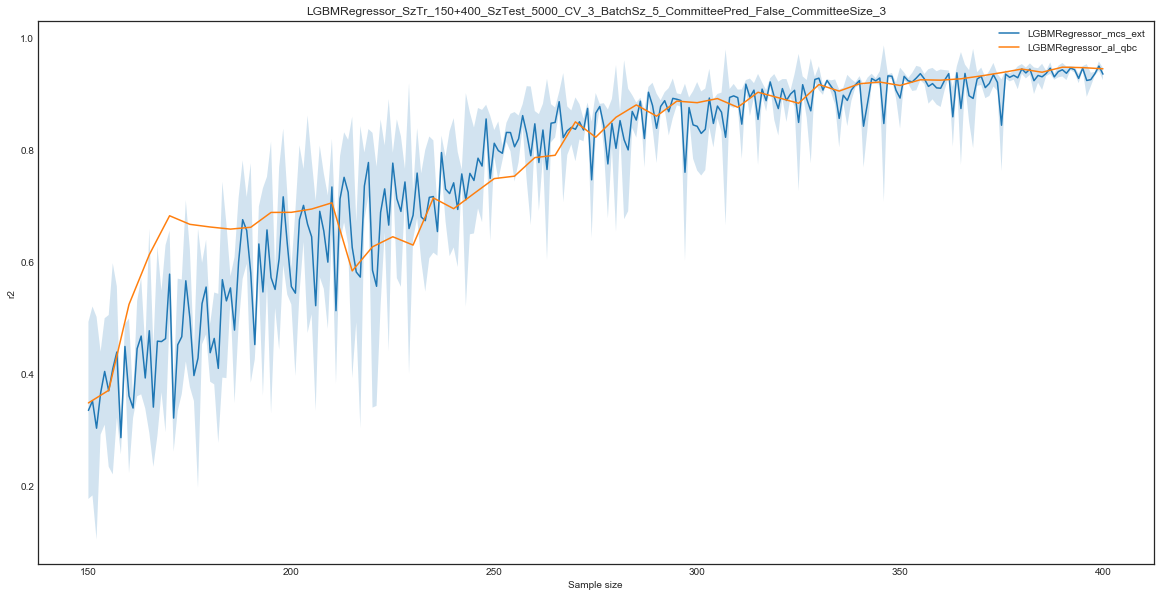

In [34]:
def plot_learning_curve_r2(df_target, label, title=''):
    df_target_filt = df_target[df_target.Model == mdl]
    df_target_mean = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.mean().reset_index()
    df_target_std = df_target_filt.groupby(['Model', 'Training_Size']).r2_val.std().reset_index()
    plt.plot(df_target_mean.Training_Size, df_target_mean.r2_val, label=mdl + '_' + label, linestyle='-')
    plt.fill_between(df_target_mean.Training_Size, df_target_mean.r2_val - df_target_std.r2_val,
                     df_target_mean.r2_val + df_target_std.r2_val, alpha=0.2)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('r2')
    ax.legend(loc='best')
    plt.title(title)
    return plt

metadata = pred_key + '_SzTr_' + str(seedSize) + '+' + str(size_train_set) + '_SzTest_' + str(
    size_test_set) + '_CV_' + str(cv_folds) + '_BatchSz_' + str(batchSize) + '_CommitteePred_' + str(
    committee_predictor) + '_CommitteeSize_' + str(numCommitteeMembers)

# res_df_qbc_filt = res_df_qbc[res_df_qbc['Training_Size'].isin(res_df_lhc.Training_Size.unique())]
# res_df_al_gpr_filt = res_df_al_gpr[res_df_al_gpr['Training_Size'].isin(res_df_lhc.Training_Size.unique())]

for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        #plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

In [10]:
for mdl in res_df_random.Model.unique():
    with plt.style.context('seaborn-white'):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
        plot_learning_curve_r2(res_df_random, 'mcs_ext', metadata)
        #plot_learning_curve_r2(res_df_lhc, 'lhc', metadata)
        plot_learning_curve_r2(res_df_qbc, 'al_qbc', metadata)
        plot_learning_curve_r2(res_df_al_gpr, 'al_gpr', metadata)
        # fig.savefig('al_lhc_mcs_results' + mdl + '.png', dpi=300)
        plt.show()

NameError: name 'res_df_random' is not defined